In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"

In [3]:
model = AutoModelForMaskedLM.from_pretrained("./results_masked/checkpoint-39000", output_hidden_states=True)

In [4]:
from json import load, loads

import numpy as np
import pandas as pd

data = []
with open("arxiv.json", "r") as f:  # read arxiv data with metadata (source: https://www.kaggle.com/datasets/Cornell-University/arxiv)
    for i, datum in enumerate(f):
        if i % 1000 == 0:
            print(end=".")
        if i % 100000 == 0:
            print()
        if (
            "cs.LG" not in datum.split('"categories"')[-1].split(",")[0]
        ):  # parse ML articles only (cs.LG)
            continue
        try:
            datum = loads(datum.strip())
            data.append(datum)
        except:
            pass

data = pd.DataFrame(data)

# top 5 secondary categories (categories other than ML)
categories = list(data.categories.str.split().explode().value_counts()[1:6].keys())


def get_secondary_category(c):
    for cat in categories:
        if cat in c.split(" "):
            return cat
    else:
        return "-"


data["secondary_category"] = data.categories.apply(get_secondary_category)
data = data[data.secondary_category != "-"].reset_index(drop=True)

# stratified sampling of secondary categories
data = (
    data.groupby("secondary_category")
    .sample(3500, replace=False)
    .reset_index(drop=True)
)

data.info()

.
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.........................................................................................

In [5]:
import re
REGEX_MULTI_SPACE = re.compile("\s+")
def preprocess_text(s):
    return re.sub(REGEX_MULTI_SPACE, " ", s).strip()
data["title"] = data.title.apply(preprocess_text)

from datasets import Dataset
titles = Dataset.from_list(data[["title"]].to_dict(orient="records"))

In [6]:
from functools import partial

def tokenize_function(tokenizer, examples):
    return tokenizer(
        examples["title"],
        truncation=True,
        padding=False, # padding is too memory-intensive
    )


partial_tokenize_function = partial(tokenize_function, tokenizer)

tokens = titles.map(
    partial_tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=titles.column_names,
)

Map (num_proc=4):   0%|          | 0/17500 [00:00<?, ? examples/s]

### Treatment Case: distilroberta with `aalksii/ml-arxiv-papers` dataset fine-tuning

In [7]:
import torch
def get_trf_vector(model, t):
    input_ids = torch.tensor([t["input_ids"]])
    outputs = model(input_ids=input_ids)
    vector = outputs.hidden_states[-1][-1][-1].detach().numpy()
    return vector

partial_get_trf_vector = partial(get_trf_vector, model)

# batch-wise vectorization (too much for my computer)
# vectors = tokens.map(
#     partial_get_trf_vector,
#     batched=True,
#     num_proc=1,
#     remove_columns=tokens.column_names,
# )

# instance-wise vectorization
from tqdm.notebook import tqdm
vectors = np.vstack([partial_get_trf_vector(t) for t in tqdm(tokens)])

  0%|          | 0/17500 [00:00<?, ?it/s]

### Control Case: distilroberta without fine-tuning

In [8]:
model_control = AutoModelForMaskedLM.from_pretrained(
    "distilroberta-base", output_hidden_states=True
)
partial_get_trf_vector_control = partial(get_trf_vector, model_control)
vectors_control = np.vstack([partial_get_trf_vector_control(t) for t in tqdm(tokens)])

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/17500 [00:00<?, ?it/s]

### Visualize vectors using UMAP

In [9]:
from umap import UMAP
from sklearn.preprocessing import robust_scale


# def preprocess(x):
#     if type(x) != pd.DataFrame:
#         x = pd.DataFrame(x)
#     return scale(
#         x.clip(lower=x.quantile(0.05), upper=x.quantile(0.95), axis=1)
#     )


def preprocess(x):
    return robust_scale(x, quantile_range=(10, 90), unit_variance=True)


umap = UMAP(n_jobs=-1, metric="cosine", min_dist=0.1).fit_transform(vectors)
umap_control = UMAP(n_jobs=-1, metric="cosine", min_dist=0.1).fit_transform(
    vectors_control
)
umap = pd.DataFrame(preprocess(umap))
umap_control = pd.DataFrame(preprocess(umap_control))

In [10]:
umap_with_cat = pd.concat(
    [umap.rename(columns=str), data["secondary_category"].reset_index(drop=True)],
    axis=1,
)
umap_with_cat_control = pd.concat(
    [
        umap_control.rename(columns=str),
        data["secondary_category"].reset_index(drop=True),
    ],
    axis=1,
)

In [11]:
categories

['stat.ML', 'cs.AI', 'cs.CV', 'cs.CL', 'cs.CR']

In [12]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 6)

def compare(other_cat):

    fig, (ax1, ax2) = plt.subplots(1, 2)

    (
        umap_with_cat_control.assign(is_other=lambda x: x["secondary_category"] == other_cat)
        .round(1)
        .groupby(["0", "1"])["is_other"]
        .agg(["mean", "count"])
        .rename(columns={"mean": f"P({other_cat})"})
        .reset_index()
        .plot.scatter(
            "0",
            "1",
            c=f"P({other_cat})",
            s="count",
            cmap="seismic_r",
            title="Without Fine-Tuning",
            ax=ax1,
        ),
    )

    (
        umap_with_cat.assign(is_other=lambda x: x["secondary_category"] == other_cat)
        .round(1)
        .groupby(["0", "1"])["is_other"]
        .agg(["mean", "count"])
        .rename(columns={"mean": f"P({other_cat})"})
        .reset_index()
        .plot.scatter(
            "0",
            "1",
            c=f"P({other_cat})",
            s="count",
            cmap="seismic_r",
            title="With Fine-Tuning",
            ax=ax2,
        ),
    )

### Subcategories have clearer, better boundaries after fine-tuning

*The blues are more together*

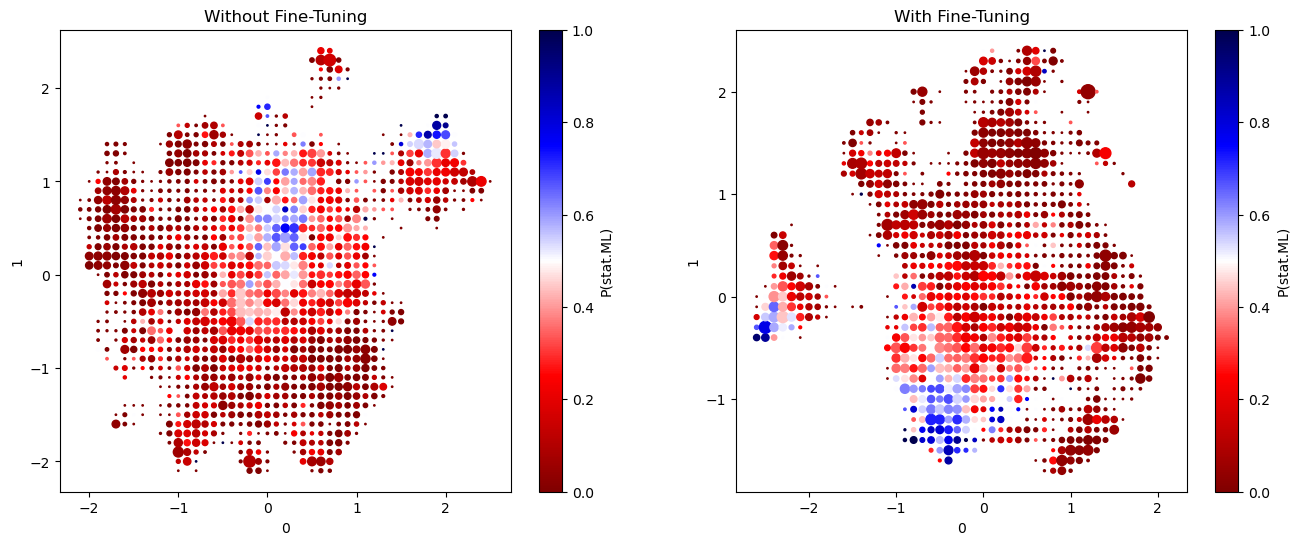

In [13]:
compare(other_cat="stat.ML")

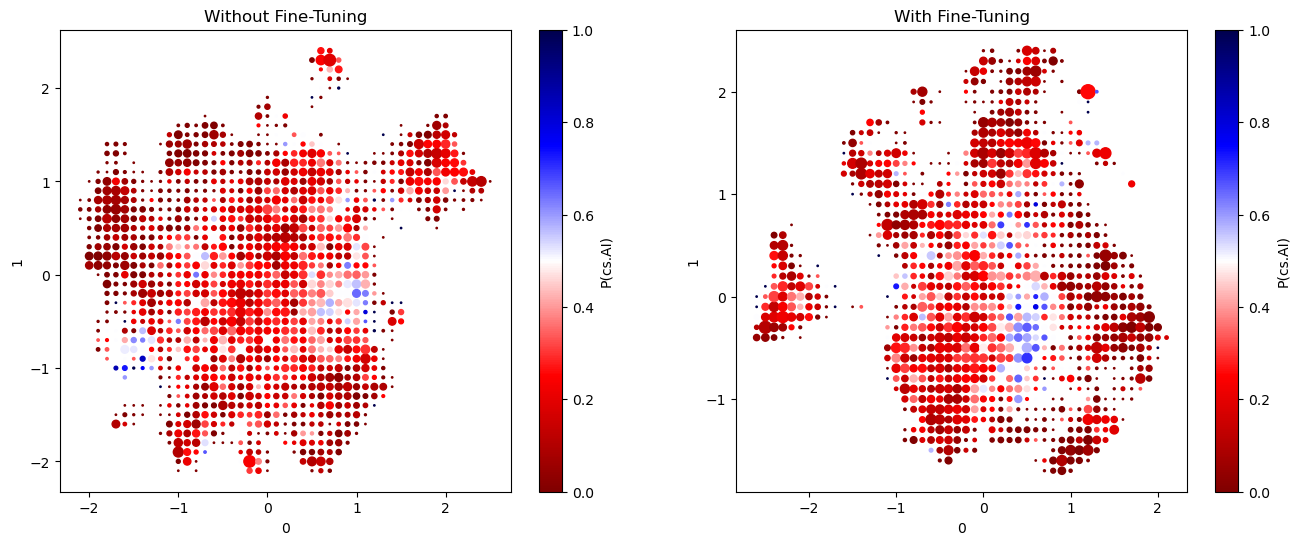

In [14]:
compare(other_cat="cs.AI")

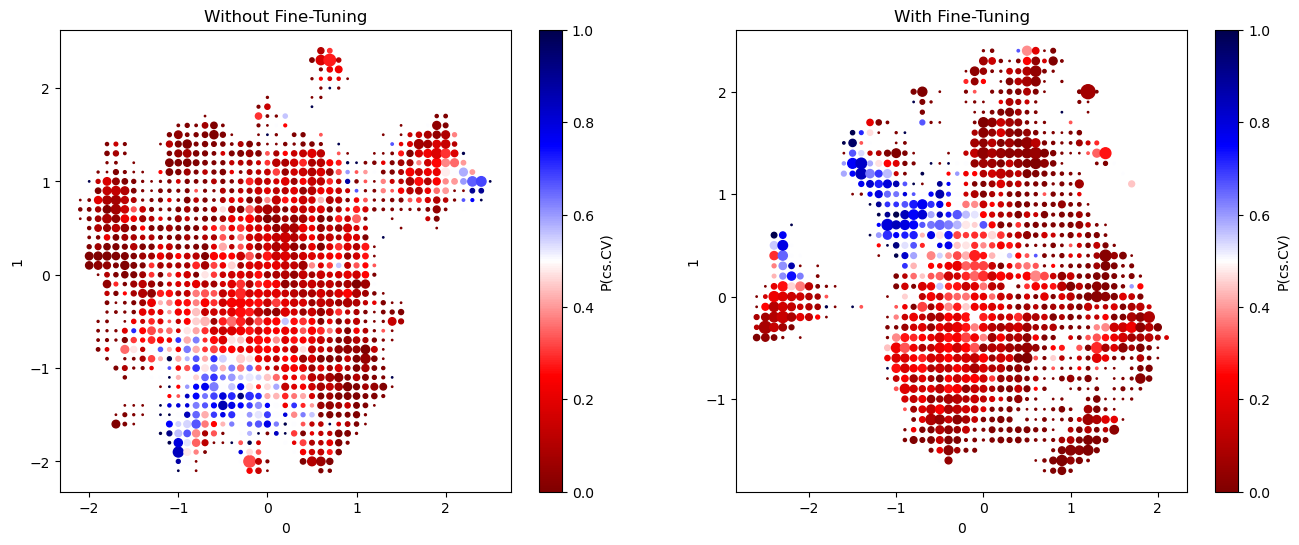

In [15]:
compare(other_cat="cs.CV")

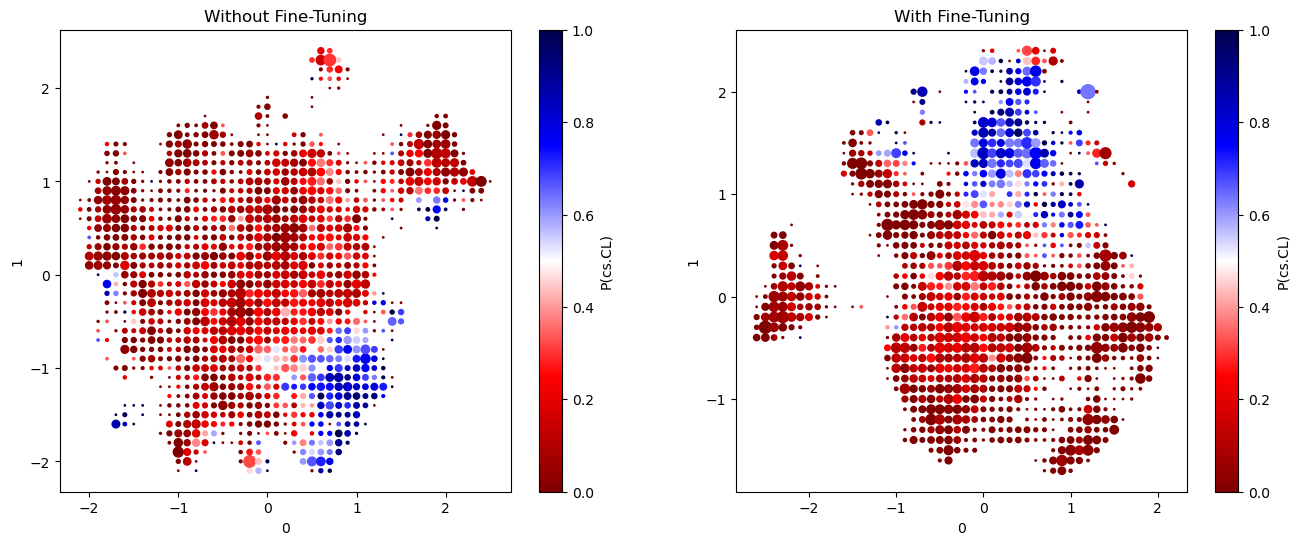

In [16]:
compare(other_cat="cs.CL")

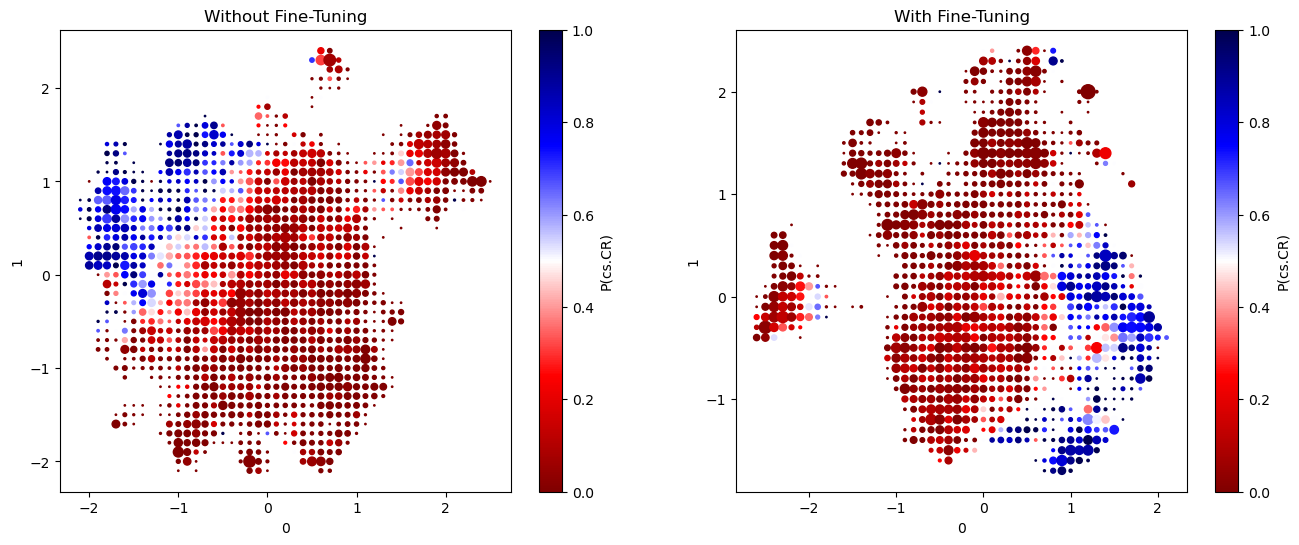

In [17]:
compare(other_cat="cs.CR")

Without vs With Fine-Tuning
CR and CL clusters are more pronounced


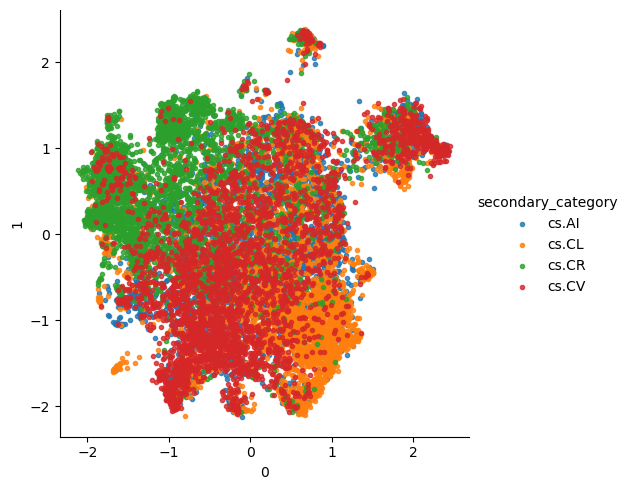

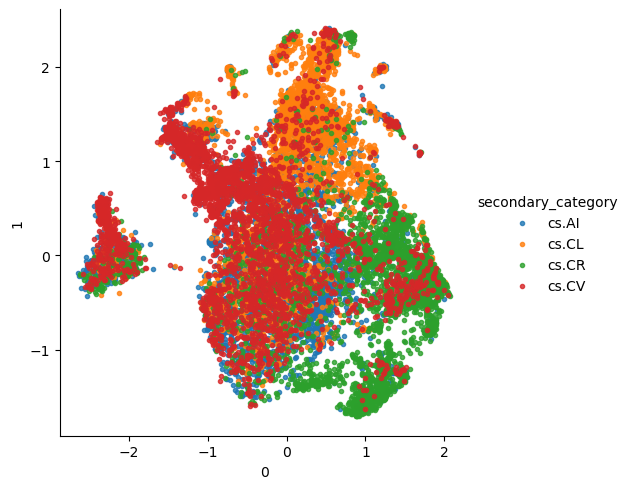

In [18]:
import seaborn as sns

print("Without vs With Fine-Tuning")
print("CR and CL clusters are more pronounced")

sns.lmplot(
    x="0",
    y="1",
    data=umap_with_cat_control[umap_with_cat_control.secondary_category != "stat.ML"],
    hue="secondary_category",
    fit_reg=False,
    markers=".",
)

_ = sns.lmplot(
    x="0",
    y="1",
    data=umap_with_cat[umap_with_cat.secondary_category != "stat.ML"],
    hue="secondary_category",
    fit_reg=False,
    markers=".",
)

### Most similar title (cosine similarity)

*More coherent matches*

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(vectors)
similarities[similarities >= 0.999] = 0

similarities_control = cosine_similarity(vectors_control)
similarities_control[similarities_control >= 0.999] = 0

In [20]:
pd.set_option("max_colwidth", 200)

comparisons = pd.DataFrame(
    {
        "title": data.title,
        "most_similar_title_finetuned": data.iloc[pd.Series(similarities.argmax(axis=1))][
            "title"
        ].reset_index(drop=True),
    }
)

comparisons_control = pd.DataFrame(
    {
        "title": data.title,
        "most_similar_title_control": data.iloc[pd.Series(similarities_control.argmax(axis=1))][
            "title"
        ].reset_index(drop=True),
    }
)

comparisons.merge(comparisons_control, on="title").sample(10)

,title,most_similar_title_finetuned,most_similar_title_control
17252,Modeling the Biological Pathology Continuum with HSIC-regularized Wasserstein Auto-encoders,Domain Adaptation with Morphologic Segmentation,Complementary Classifier Induced Partial Label Learning
13330,3D Human Shape and Pose from a Single Low-Resolution Image with Self-Supervised Learning,Self-Supervised 3D Face Reconstruction via Conditional Estimation,Sample Factory: Egocentric 3D Control from Pixels at 100000 FPS with Asynchronous Reinforcement Learning
7887,Semi-Targeted Model Poisoning Attack on Federated Learning via Backward Error Analysis,Data Poisoning Attacks on Federated Machine Learning,Test-time Detection and Repair of Adversarial Samples via Masked Autoencoder
11004,On Conditioning the Input Noise for Controlled Image Generation with Diffusion Models,Conditional Probability Models for Deep Image Compression,Editing Models with Task Arithmetic
8123,Algorithmic Stability for Adaptive Data Analysis,Evolutionary Optimization of Deep Learning Activation Functions,Dynamic Hierarchical Empirical Bayes: A Predictive Model Applied to Online Advertising
6957,Bidirectional Context-Aware Hierarchical Attention Network for Document Understanding,Multitask Learning for Large-scale Semantic Change Detection,Memory Efficient Neural Processes via Constant Memory Attention Block
4012,Graph Refinement for Coreference Resolution,Manifold Denoising by Nonlinear Robust Principal Component Analysis,Domain Generalization for Domain-Linked Classes
7947,Collaborative Self Organizing Map with DeepNNs for Fake Task Prevention in Mobile Crowdsensing,Exploiting Data Sparsity in Secure Cross-Platform Social Recommendation,Harnessing the Power of Ego Network Layers for Link Prediction in Online Social Networks
5779,Contextual Skipgram: Training Word Representation Using Context Information,Exploring Representation Learning for Small-Footprint Keyword Spotting,Imputing Knowledge Tracing Data with Subject-Based Training via LSTM Variational Autoencoders Frameworks
15366,Theoretical limitations of Encoder-Decoder GAN architectures,Optimal Transport Based Generative Autoencoders,Persistent Homology and Graphs Representation Learning


### Save sampled metadata and vectors for next step

In [21]:
data.to_csv("data_samples.csv")
np.save("vectors_samples.npy", vectors)